# Instructions
Using SimPy, write a process simulation that includes waiting time (discrete event simulation).  You may use any topic of interest to you.  Write the simulation and all of the following in Jupyter.

Each element is worth 5 points and will be graded using the rubric shown here.

1.  State the problem and its significance.

2.  Provide a flow-chart model. 

3.  Simulate the process for the appropriate number of iterations (justify)

4.  Justify the validity of the model and discuss how you verified it.

5.  State  your conclusions/ findings from the model. 

6.  Generate appropriate graphs (more than one) to illustrate the results and provide a PowerPoint presentation to share with your colleagues.  Post this to the discussion. 

Be sure that your code works!

### 1. State the problem and its significance

The whole inspiration for this simulation idea goes all the way back to when I worked for the town planner in High School. In my hometowm of Stoneham, Massachuessetts there were some particularly awful and dangerous intersections, left turns and peculiar roads. However, there is one intersection in town that is notoriously and extraordinarily terrible. On the north side of Stoneham the intersection of North Street and Main Street sets up a unique opportunity for crashes. On the Main Street there are entrances and exits to one of the busiest highways in the state (i95) and North Street is one of the most popular streets to get to surrounding towns, so it also receives a lot of traffic from the highways.

When I worked for the town planner this was deemed one of the most dangerous intersections both in town and in the surrounding towns. I have always been interested in this, experiencing first-hand how truly awful it is.

### 2.  Provide a flow-chart model.

### 3.  Simulate the process for the appropriate number of iterations (justify)

### 4.  Justify the validity of the model and discuss how you verified it.

### 5.  State  your conclusions/ findings from the model. 

### Load initial packages

In [2]:
from modsim import *
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import simpy as sp


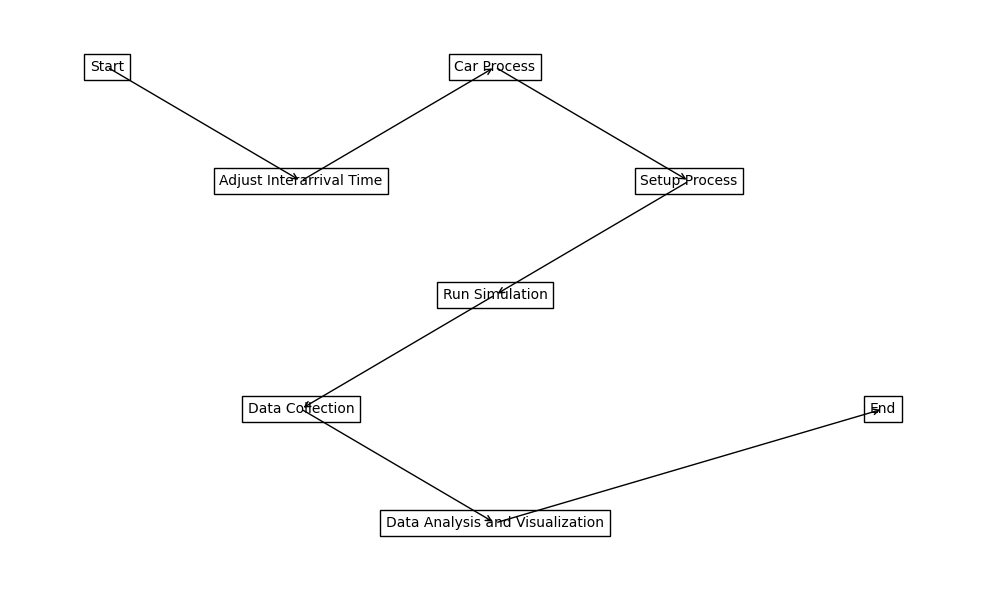

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Function to draw an arrow
def draw_arrow(ax, start, end):
    ax.annotate("", xy=end, xycoords='data', xytext=start, textcoords='data',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')

# Nodes as points [(x, y), ...]
nodes = {'Start': (1, 9), 'Adjust Interarrival Time': (3, 7), 'Car Process': (5, 9),
         'Setup Process': (7, 7), 'Run Simulation': (5, 5), 'Data Collection': (3, 3),
         'Data Analysis and Visualization': (5, 1), 'End': (9, 3)}

# Draw nodes
for node, (x, y) in nodes.items():
    ax.text(x, y, node, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black'))

# Draw edges
edges = [('Start', 'Adjust Interarrival Time'), ('Adjust Interarrival Time', 'Car Process'),
         ('Car Process', 'Setup Process'), ('Setup Process', 'Run Simulation'),
         ('Run Simulation', 'Data Collection'), ('Data Collection', 'Data Analysis and Visualization'),
         ('Data Analysis and Visualization', 'End')]

for start, end in edges:
    start_pos, end_pos = nodes[start], nodes[end]
    draw_arrow(ax, start_pos, end_pos)

plt.tight_layout()
plt.show()

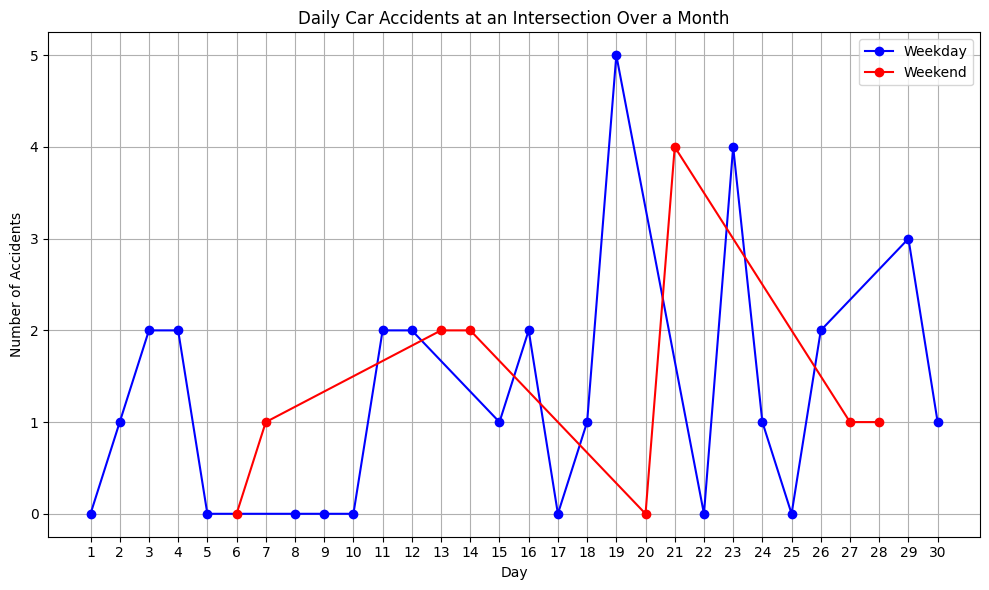

In [9]:
import simpy
import pandas as pd
import matplotlib.pyplot as plt
import random

# Constants
DAYS_IN_MONTH = 30
TOTAL_CARS = 30000
BASE_INTERARRIVAL_TIME = DAYS_IN_MONTH * 24 * 60 * 60 / TOTAL_CARS  # Base spread of cars over the month

# Time periods (in hours)
MORNING_PEAK_START, MORNING_PEAK_END = 6, 10
EVENING_PEAK_START, EVENING_PEAK_END = 16, 20
WEEKEND = [5, 6]  # Saturday and Sunday

def adjust_interarrival_time(current_time):
    """Adjust interarrival time based on the current simulation time."""
    hour = (current_time // (60*60)) % 24
    day = (current_time // (24*60*60)) % 7
    
    if day in WEEKEND:
        return BASE_INTERARRIVAL_TIME * 1.5  # Slower on weekends
    elif MORNING_PEAK_START <= hour < MORNING_PEAK_END or EVENING_PEAK_START <= hour < EVENING_PEAK_END:
        return BASE_INTERARRIVAL_TIME * 0.5  # Busier in morning and evening
    else:
        return BASE_INTERARRIVAL_TIME * 1.2  # Slower in the afternoon

class Intersection:
    def __init__(self, env):
        self.env = env
        self.accidents = 0

    def pass_through(self):
        if random.random() < 0.001:  # Adjusted probability for demonstration
            self.accidents += 1

def car(env, intersection):
    intersection.pass_through()
    yield env.timeout(1)
    if random.random() < 0.3:
        yield env.timeout(random.randint(1, 10))
        intersection.pass_through()

def setup(env, intersection):
    while True:
        interarrival_time = adjust_interarrival_time(env.now)
        yield env.timeout(interarrival_time)
        env.process(car(env, intersection))

results = []
for day in range(1, DAYS_IN_MONTH + 1):
    env = simpy.Environment()
    intersection = Intersection(env)
    env.process(setup(env, intersection))
    env.run(until=24*60*60)
    day_type = 'Weekend' if day % 7 in [6, 0] else 'Weekday'  # Assuming 1st day is a Monday
    results.append({'Day': day, 'Accidents': intersection.accidents, 'DayType': day_type})

# Convert to DataFrame
df = pd.DataFrame(results)

# Plotting
plt.figure(figsize=(10, 6))

# Plot Weekdays
weekdays = df[df['DayType'] == 'Weekday']
plt.plot(weekdays['Day'], weekdays['Accidents'], marker='o', linestyle='-', label='Weekday', color='blue')

# Plot Weekends
weekends = df[df['DayType'] == 'Weekend']
plt.plot(weekends['Day'], weekends['Accidents'], marker='o', linestyle='-', label='Weekend', color='red')

plt.xlabel('Day')
plt.ylabel('Number of Accidents')
plt.title('Daily Car Accidents at an Intersection Over a Month')
plt.xticks(range(1, DAYS_IN_MONTH + 1))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

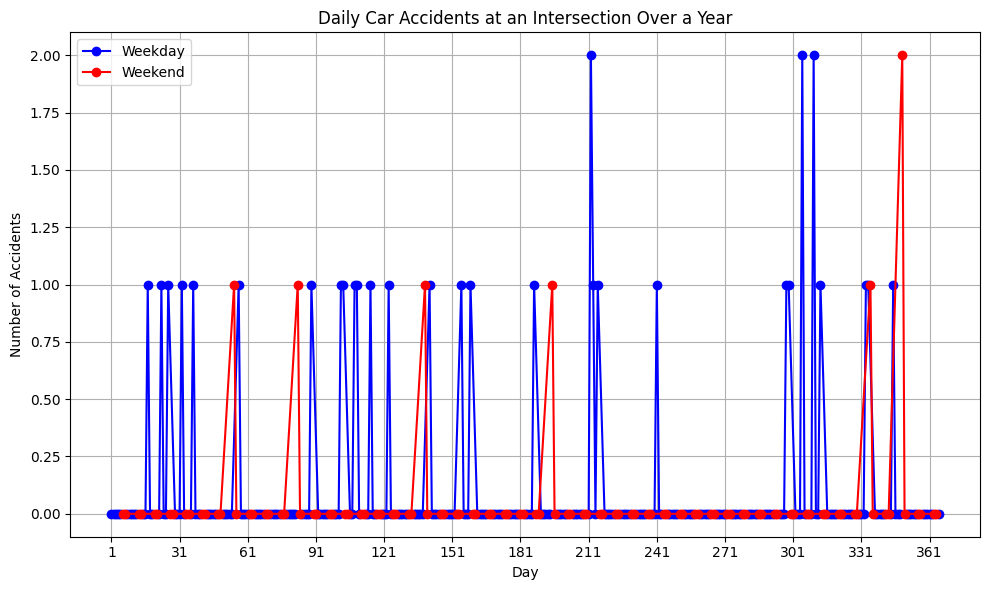

In [21]:
import simpy
import pandas as pd
import matplotlib.pyplot as plt
import random

# Constants
DAYS_IN_YEAR = 365
TOTAL_CARS = 30000
BASE_INTERARRIVAL_TIME = DAYS_IN_YEAR * 24 * 60 * 60 / TOTAL_CARS  # Base spread of cars over the year

# Time periods (in hours)
MORNING_PEAK_START, MORNING_PEAK_END = 6, 10
EVENING_PEAK_START, EVENING_PEAK_END = 16, 20
WEEKEND = [5, 6]  # Saturday and Sunday

def adjust_interarrival_time(current_time):
    """Adjust interarrival time based on the current simulation time."""
    hour = (current_time // (60*60)) % 24
    day = (current_time // (24*60*60)) % 7
    
    if day in WEEKEND:
        return BASE_INTERARRIVAL_TIME * 1.5  # Slower on weekends
    elif MORNING_PEAK_START <= hour < MORNING_PEAK_END or EVENING_PEAK_START <= hour < EVENING_PEAK_END:
        return BASE_INTERARRIVAL_TIME * 0.5  # Busier in morning and evening
    else:
        return BASE_INTERARRIVAL_TIME * 1.2  # Slower in the afternoon

class Intersection:
    def __init__(self, env):
        self.env = env
        self.accidents = 0

    def pass_through(self):
        if random.random() < 0.001:  # Adjusted probability for demonstration
            self.accidents += 1

def car(env, intersection):
    intersection.pass_through()
    yield env.timeout(1)
    if random.random() < 0.3:
        yield env.timeout(random.randint(1, 10))
        intersection.pass_through()

def setup(env, intersection):
    while True:
        interarrival_time = adjust_interarrival_time(env.now)
        yield env.timeout(interarrival_time)
        env.process(car(env, intersection))

results = []
for day in range(1, DAYS_IN_YEAR + 1):
    env = simpy.Environment()
    intersection = Intersection(env)
    env.process(setup(env, intersection))
    env.run(until=24*60*60)  # Run for one day (24 hours)
    day_type = 'Weekend' if day % 7 in [6, 0] else 'Weekday'  # Assuming 1st day is a Monday
    results.append({'Day': day, 'Accidents': intersection.accidents, 'DayType': day_type})

# Convert to DataFrame
df = pd.DataFrame(results)

# Plotting
plt.figure(figsize=(10, 6))

# Plot Weekdays
weekdays = df[df['DayType'] == 'Weekday']
plt.plot(weekdays['Day'], weekdays['Accidents'], marker='o', linestyle='-', label='Weekday', color='blue')

# Plot Weekends
weekends = df[df['DayType'] == 'Weekend']
plt.plot(weekends['Day'], weekends['Accidents'], marker='o', linestyle='-', label='Weekend', color='red')

plt.xlabel('Day')
plt.ylabel('Number of Accidents')
plt.title('Daily Car Accidents at an Intersection Over a Year')
plt.xticks(range(1, DAYS_IN_YEAR + 1, 30))  # Showing ticks every 30 days
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

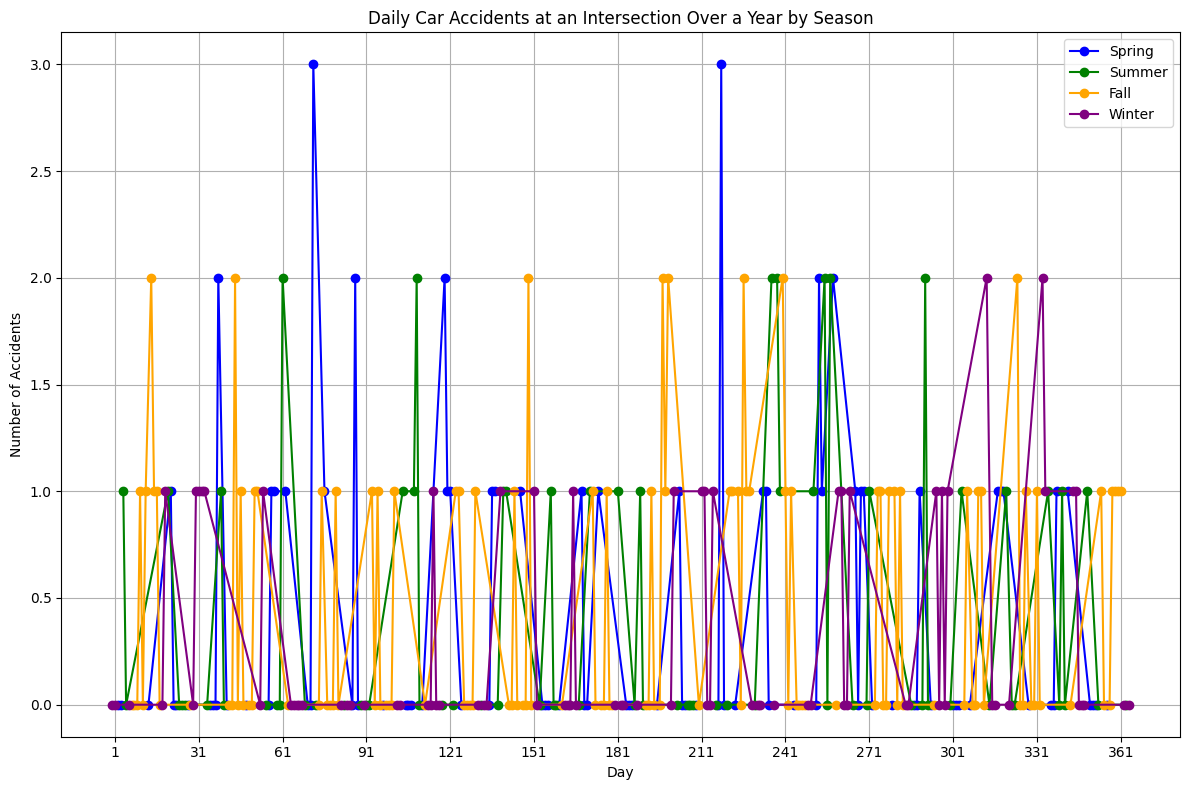

In [14]:
import simpy
import pandas as pd
import matplotlib.pyplot as plt
import random

# Constants
DAYS_IN_YEAR = 365  # Total days in a year
TOTAL_CARS = 30000
BASE_INTERARRIVAL_TIME = DAYS_IN_YEAR * 24 * 60 * 60 / TOTAL_CARS  # Base spread of cars over the year

# Time periods (in hours)
MORNING_PEAK_START, MORNING_PEAK_END = 6, 10
EVENING_PEAK_START, EVENING_PEAK_END = 16, 20
WEEKEND = [5, 6]  # Saturday and Sunday

# Define seasons and their respective weather conditions and accident probabilities
SEASONS = {
    'Spring': {'weather': 'Rain', 'accident_prob': 0.0025},
    'Summer': {'weather': 'Clear', 'accident_prob': 0.001},
    'Fall': {'weather': 'Clear', 'accident_prob': 0.001},
    'Winter': {'weather': 'Snow', 'accident_prob': 0.01}  # Higher accident probability in snow
}

def get_season(month):
    """Determine season based on the month."""
    if month in range(3, 6):  # March to May: Spring
        return 'Spring'
    elif month in range(6, 9):  # June to August: Summer
        return 'Summer'
    elif month in range(9, 12):  # September to November: Fall
        return 'Fall'
    else:  # December to February: Winter
        return 'Winter'

def adjust_interarrival_time(current_time, season):
    """Adjust interarrival time based on the current simulation time and season."""
    hour = (current_time // (60*60)) % 24
    day = (current_time // (24*60*60)) % 7
    
    if day in WEEKEND:
        return BASE_INTERARRIVAL_TIME * 1.5  # Slower on weekends
    elif MORNING_PEAK_START <= hour < MORNING_PEAK_END or EVENING_PEAK_START <= hour < EVENING_PEAK_END:
        return BASE_INTERARRIVAL_TIME * 0.5  # Busier in morning and evening
    else:
        # Adjust based on season and weather conditions
        if SEASONS[season]['weather'] == 'Snow':
            return BASE_INTERARRIVAL_TIME * 1.5  # Slower during snow
        else:
            return BASE_INTERARRIVAL_TIME * 1.2  # Slower in the afternoon

class Intersection:
    def __init__(self, env):
        self.env = env
        self.accidents_today = 0
        self.day_count = 0  # Track the current day
        self.season = None

    def pass_through(self, season):
        """Simulate a car passing through the intersection."""
        if random.random() < SEASONS[season]['accident_prob']:
            self.accidents_today += 1
        self.season = season

def car(env, intersection, season):
    day_type = 'Weekday' if (env.now % (24*60*60)) // (24*60*60) not in WEEKEND else 'Weekend'
    intersection.pass_through(season)
    yield env.timeout(1)
    if random.random() < 0.3:
        yield env.timeout(random.randint(1, 10))
        intersection.pass_through(season)
    # Check if the day has changed and reset daily accidents count
    current_day = (env.now // (24*60*60)) % DAYS_IN_YEAR + 1
    if current_day != intersection.day_count:
        results.append({'Day': intersection.day_count, 'DayType': day_type, 'Accidents': intersection.accidents_today, 'Season': intersection.season})
        intersection.accidents_today = 0  # Reset daily accidents count
        intersection.day_count = current_day

def setup(env, intersection):
    """Setup the simulation environment."""
    month = 1
    while True:
        season = get_season(month)
        interarrival_time = adjust_interarrival_time(env.now, season)
        yield env.timeout(interarrival_time)
        env.process(car(env, intersection, season))
        month += 1
        if month > 12:
            month = 1

results = []
env = simpy.Environment()
intersection = Intersection(env)
env.process(setup(env, intersection))
env.run(until=DAYS_IN_YEAR * 24 * 60 * 60)

# Convert to DataFrame
df = pd.DataFrame(results)

# Plotting
plt.figure(figsize=(12, 8))

# Plot each season separately
for season, color in zip(SEASONS.keys(), ['blue', 'green', 'orange', 'purple']):
    season_data = df[df['Season'] == season]
    plt.plot(season_data['Day'], season_data['Accidents'], marker='o', linestyle='-', label=season, color=color)

plt.xlabel('Day')
plt.ylabel('Number of Accidents')
plt.title('Daily Car Accidents at an Intersection Over a Year by Season')
plt.xticks(range(1, DAYS_IN_YEAR + 1, 30))  # Show x-axis ticks every 30 days (approximately every month)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### What happens if this intersection is signalized (meaning a left turn light, specifically on either side of main street and north street)
* A study from the Department of Transportation showed that signalizing both sides of a major road for left turns has an estimated reduction in all collisions of 62% and suggests it could be even more depending on the specific area.
* While they used a more advanced model to show this, it should still apply well to my simulation.

So lets see what happens to the seasonal simulation when the probabiity of a crash at any time is reduced 62%

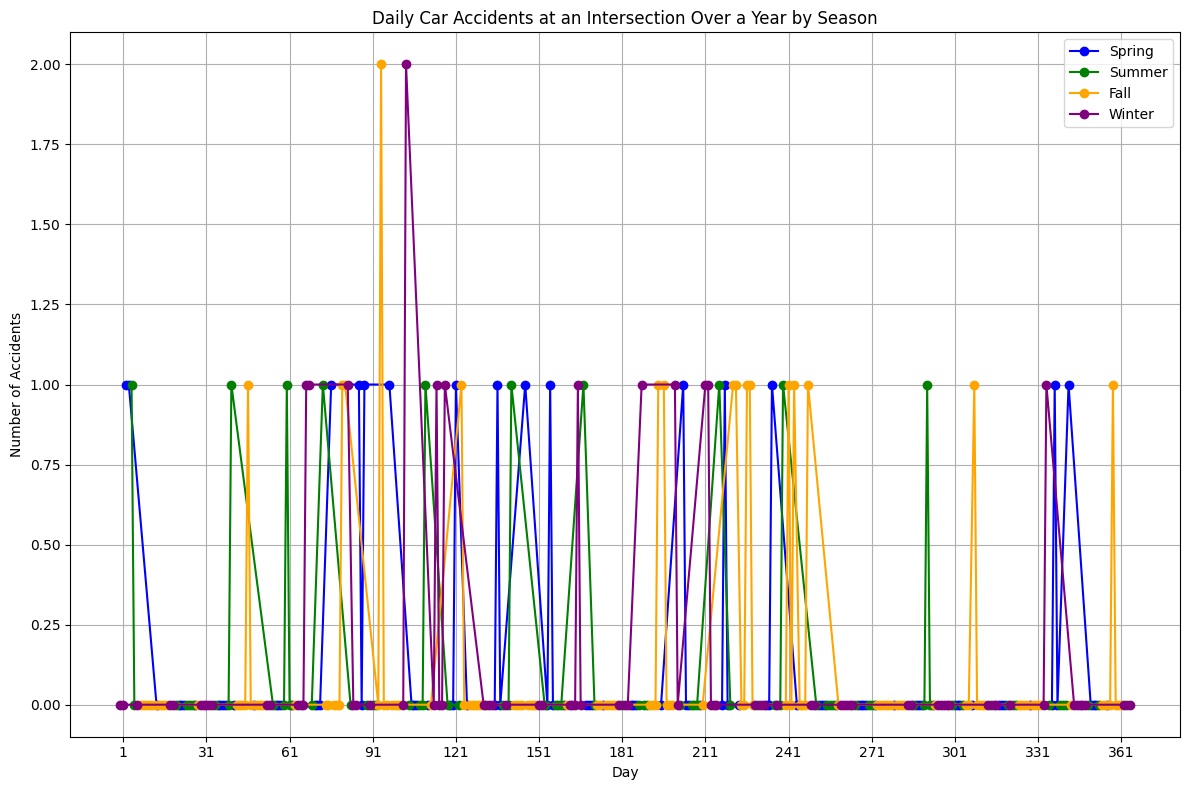

In [15]:
import simpy
import pandas as pd
import matplotlib.pyplot as plt
import random

# Constants
DAYS_IN_YEAR = 365  # Total days in a year
TOTAL_CARS = 30000
BASE_INTERARRIVAL_TIME = DAYS_IN_YEAR * 24 * 60 * 60 / TOTAL_CARS  # Base spread of cars over the year

# Time periods (in hours)
MORNING_PEAK_START, MORNING_PEAK_END = 6, 10
EVENING_PEAK_START, EVENING_PEAK_END = 16, 20
WEEKEND = [5, 6]  # Saturday and Sunday

# Define seasons and their respective weather conditions and accident probabilities
SEASONS = {
    'Spring': {'weather': 'Rain', 'accident_prob': 0.0025 * 0.38},
    'Summer': {'weather': 'Clear', 'accident_prob': 0.001 * 0.38},
    'Fall': {'weather': 'Clear', 'accident_prob': 0.001 * 0.38},
    'Winter': {'weather': 'Snow', 'accident_prob': 0.01 * 0.38}  # Higher accident probability in snow
}

def get_season(month):
    """Determine season based on the month."""
    if month in range(3, 6):  # March to May: Spring
        return 'Spring'
    elif month in range(6, 9):  # June to August: Summer
        return 'Summer'
    elif month in range(9, 12):  # September to November: Fall
        return 'Fall'
    else:  # December to February: Winter
        return 'Winter'

def adjust_interarrival_time(current_time, season):
    """Adjust interarrival time based on the current simulation time and season."""
    hour = (current_time // (60*60)) % 24
    day = (current_time // (24*60*60)) % 7
    
    if day in WEEKEND:
        return BASE_INTERARRIVAL_TIME * 1.5  # Slower on weekends
    elif MORNING_PEAK_START <= hour < MORNING_PEAK_END or EVENING_PEAK_START <= hour < EVENING_PEAK_END:
        return BASE_INTERARRIVAL_TIME * 0.5  # Busier in morning and evening
    else:
        # Adjust based on season and weather conditions
        if SEASONS[season]['weather'] == 'Snow':
            return BASE_INTERARRIVAL_TIME * 1.5  # Slower during snow
        else:
            return BASE_INTERARRIVAL_TIME * 1.2  # Slower in the afternoon

class Intersection:
    def __init__(self, env):
        self.env = env
        self.accidents_today = 0
        self.day_count = 0  # Track the current day
        self.season = None

    def pass_through(self, season):
        """Simulate a car passing through the intersection."""
        if random.random() < SEASONS[season]['accident_prob']:
            self.accidents_today += 1
        self.season = season

def car(env, intersection, season):
    day_type = 'Weekday' if (env.now % (24*60*60)) // (24*60*60) not in WEEKEND else 'Weekend'
    intersection.pass_through(season)
    yield env.timeout(1)
    if random.random() < 0.3:
        yield env.timeout(random.randint(1, 10))
        intersection.pass_through(season)
    # Check if the day has changed and reset daily accidents count
    current_day = (env.now // (24*60*60)) % DAYS_IN_YEAR + 1
    if current_day != intersection.day_count:
        results.append({'Day': intersection.day_count, 'DayType': day_type, 'Accidents': intersection.accidents_today, 'Season': intersection.season})
        intersection.accidents_today = 0  # Reset daily accidents count
        intersection.day_count = current_day

def setup(env, intersection):
    """Setup the simulation environment."""
    month = 1
    while True:
        season = get_season(month)
        interarrival_time = adjust_interarrival_time(env.now, season)
        yield env.timeout(interarrival_time)
        env.process(car(env, intersection, season))
        month += 1
        if month > 12:
            month = 1

results = []
env = simpy.Environment()
intersection = Intersection(env)
env.process(setup(env, intersection))
env.run(until=DAYS_IN_YEAR * 24 * 60 * 60)

# Convert to DataFrame
df = pd.DataFrame(results)

# Plotting
plt.figure(figsize=(12, 8))

# Plot each season separately
for season, color in zip(SEASONS.keys(), ['blue', 'green', 'orange', 'purple']):
    season_data = df[df['Season'] == season]
    plt.plot(season_data['Day'], season_data['Accidents'], marker='o', linestyle='-', label=season, color=color)

plt.xlabel('Day')
plt.ylabel('Number of Accidents')
plt.title('Daily Car Accidents at an Intersection Over a Year by Season')
plt.xticks(range(1, DAYS_IN_YEAR + 1, 30))  # Show x-axis ticks every 30 days (approximately every month)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

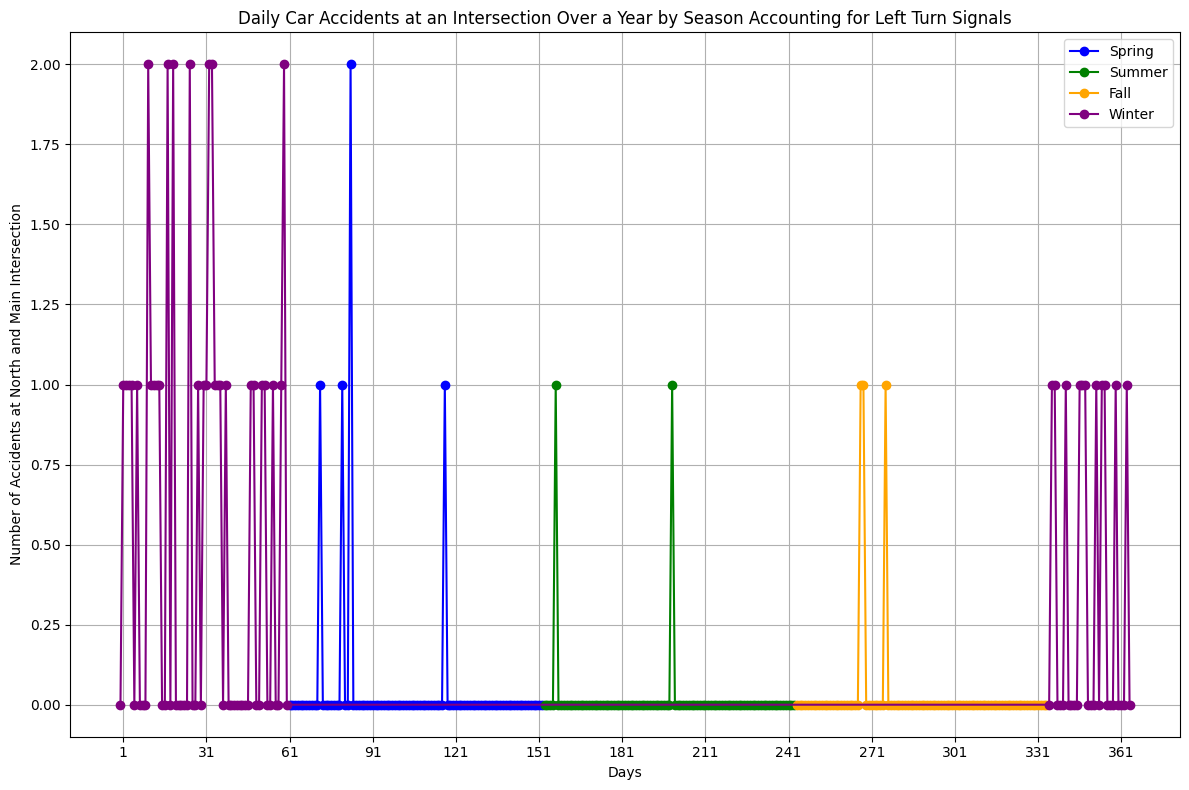

In [23]:
import simpy
import pandas as pd
import matplotlib.pyplot as plt
import random

# Constants
DAYS_IN_YEAR = 365  # Total days in a year
TOTAL_CARS = 30000
BASE_INTERARRIVAL_TIME = DAYS_IN_YEAR * 24 * 60 * 60 / TOTAL_CARS  # Base spread of cars over the year
SECONDS_IN_MONTH = (DAYS_IN_YEAR / 12) * 24 * 60 * 60  # Average seconds in a month

# Time periods (in hours)
MORNING_PEAK_START, MORNING_PEAK_END = 6, 10
EVENING_PEAK_START, EVENING_PEAK_END = 16, 20
WEEKEND = [5, 6]  # Saturday and Sunday

# Define seasons and their respective weather conditions and accident probabilities
SEASONS = {
    'Spring': {'weather': 'Rain', 'accident_prob': 0.0025 * 0.38},
    'Summer': {'weather': 'Clear', 'accident_prob': 0.001 * 0.38},
    'Fall': {'weather': 'Clear', 'accident_prob': 0.001 * 0.38},
    'Winter': {'weather': 'Snow', 'accident_prob': 0.01 * 0.38}  # Higher accident probability in snow
}

def get_season(month):
    """Determine season based on the month."""
    if month in range(3, 6):  # March to May: Spring
        return 'Spring'
    elif month in range(6, 9):  # June to August: Summer
        return 'Summer'
    elif month in range(9, 12):  # September to November: Fall
        return 'Fall'
    else:  # December to February: Winter
        return 'Winter'

def adjust_interarrival_time(current_time, season):
    """Adjust interarrival time based on the current simulation time and season."""
    hour = (current_time // (60*60)) % 24
    day = (current_time // (24*60*60)) % 7
    
    if day in WEEKEND:
        return BASE_INTERARRIVAL_TIME * 1.5  # Slower on weekends
    elif MORNING_PEAK_START <= hour < MORNING_PEAK_END or EVENING_PEAK_START <= hour < EVENING_PEAK_END:
        return BASE_INTERARRIVAL_TIME * 0.5  # Busier in morning and evening
    else:
        # Adjust based on season and weather conditions
        if SEASONS[season]['weather'] == 'Snow':
            return BASE_INTERARRIVAL_TIME * 1.5  # Slower during snow
        else:
            return BASE_INTERARRIVAL_TIME * 1.2  # Slower in the afternoon

class Intersection:
    def __init__(self, env):
        self.env = env
        self.accidents_today = 0
        self.day_count = 0  # Track the current day
        self.season = None

    def pass_through(self, season):
        """Simulate a car passing through the intersection."""
        if random.random() < SEASONS[season]['accident_prob']:
            self.accidents_today += 1
        self.season = season

def car(env, intersection, season):
    day_type = 'Weekday' if (env.now % (24*60*60)) // (24*60*60) not in WEEKEND else 'Weekend'
    intersection.pass_through(season)
    yield env.timeout(1)
    if random.random() < 0.3:
        yield env.timeout(random.randint(1, 10))
        intersection.pass_through(season)
    # Check if the day has changed and reset daily accidents count
    current_day = (env.now // (24*60*60)) % DAYS_IN_YEAR + 1
    if current_day != intersection.day_count:
        results.append({'Day': intersection.day_count, 'DayType': day_type, 'Accidents': intersection.accidents_today, 'Season': intersection.season})
        intersection.accidents_today = 0  # Reset daily accidents count
        intersection.day_count = current_day

def setup(env, intersection):
    """Setup the simulation environment."""
    while True:
        current_time = env.now
        month = int((current_time // SECONDS_IN_MONTH) % 12) + 1  # Calculate current month based on simulation time
        season = get_season(month)
        interarrival_time = adjust_interarrival_time(current_time, season)
        yield env.timeout(interarrival_time)
        env.process(car(env, intersection, season))

results = []
env = simpy.Environment()
intersection = Intersection(env)
env.process(setup(env, intersection))
env.run(until=DAYS_IN_YEAR * 24 * 60 * 60)

# Convert to DataFrame
df = pd.DataFrame(results)

# Plotting
plt.figure(figsize=(12, 8))

# Plot each season separately
for season, color in zip(SEASONS.keys(), ['blue', 'green', 'orange', 'purple']):
    season_data = df[df['Season'] == season]
    plt.plot(season_data['Day'], season_data['Accidents'], marker='o', linestyle='-', label=season, color=color)

plt.xlabel('Days')
plt.ylabel('Number of Accidents at North and Main Intersection')
plt.title('Daily Car Accidents at an Intersection Over a Year by Season Accounting for Left Turn Signals')
plt.xticks(range(1, DAYS_IN_YEAR + 1, 30))  # Show x-axis ticks every 30 days (approximately every month)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()